# LSTM Multivariate Model for Amazon, Google and Microsoft Stocks

In [ ]:
# Import libraries
from pathlib import Path
import pandas as pd
import numpy as np
import hvplot.pandas
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Assign random seed for reproducibility 
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Clean Up

In [ ]:
# Define CSV path and write to a Dataframe
csv_path = Path("/content/drive/MyDrive/Group_Project_2/AMZN_GOOG_MSFT_historical_data.csv")
stocks_df = pd.read_csv(csv_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
stocks_df.head()

,AMZN,MSFT,GOOGL
Date,,,
2016-01-04,636.73,54.790,759.41
2016-01-05,633.79,55.050,761.52
2016-01-06,632.81,54.075,759.30
2016-01-07,607.84,52.190,741.00
2016-01-08,607.23,52.330,730.92


In [ ]:
# Create individual DataFrames
amzn_df = stocks_df.drop(columns=['MSFT', 'GOOGL'])
msft_df = stocks_df.drop(columns=['AMZN', 'GOOGL'])
googl_df = stocks_df.drop(columns=['MSFT', 'AMZN'])

In [ ]:
# Create list of DataFrames
dfs = [amzn_df, msft_df, googl_df]

## Data Prep

In [ ]:
# Function to calculate RSI
def relative_strength_idx(df, n=14):
    close = df
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [ ]:
# Create EMA and RSI columns
for df in dfs: 
  df['EMA_5'] = df.ewm(5).mean().shift()
  df_rsi = relative_strength_idx(df, n=14) 
  df['RSI'] = df_rsi[df_rsi.columns[0]]

In [ ]:
# Build the LSTM model. 

def lstm_model(X_train):
  model = Sequential()

  number_units = 35
  dropout_fraction = 0.3

  # Layer 1
  model.add(LSTM(
      units=number_units,
      return_sequences=True,
      input_shape=(X_train.shape[1], 1))
      )
  model.add(Dropout(dropout_fraction))
  # Layer 2
  model.add(LSTM(units=number_units, return_sequences=True))
  model.add(Dropout(dropout_fraction))
  # Layer 3
  model.add(LSTM(units=number_units, return_sequences=True))
  model.add(Dropout(dropout_fraction))
  # Layer 4
  model.add(LSTM(units=number_units))
  model.add(Dropout(dropout_fraction))

  model.add(Dense(1))

  return model
  

## Run the Model

In [ ]:
# Predict Closing Prices

scalers = {}
test = []
pred_results = []

for df in dfs:
  scaler = MinMaxScaler()

  # Slice the data for after the shock
  df = df.loc['2020-03-01': '2021-05-03']

  # Split data into feature(X) and target(y)
  X = df
  y = df.iloc[:,0]
  y = np.array(y).reshape(-1,1)

  # Split into training and testing sets
  split_ratio = 0.8
  split = int(split_ratio * len(X))
  X_train = X[: split]
  X_test = X[split:]
  y_train = y[: split]
  y_test = y[split:]

  # Scale the data
  scaler.fit(X)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  scaler.fit(y)
  y_train = scaler.transform(y_train)
  y_test = scaler.transform(y_test)
  
  test.append(y_test)

  scalers[df.columns[0]]=scaler

  # Reshape the data
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  # Call the LSTM model function
  model = lstm_model(X_train)

  # Compile the model
  model.compile(optimizer="adamax", loss="mean_squared_error")

  # Fit the model
  model.fit(X_train, y_train, epochs=25, shuffle=False, batch_size=2)

  print(model.evaluate(X_test, y_test))

  # Make predictions
  predicted = model.predict(X_test)

  pred_results.append(predicted)

Epoch 1/25
118/118 [==============================] - 7s 7ms/step - loss: 0.0715
Epoch 2/25
118/118 [==============================] - 1s 7ms/step - loss: 0.1242
Epoch 3/25
118/118 [==============================] - 1s 7ms/step - loss: 0.1069
Epoch 4/25
118/118 [==============================] - 1s 7ms/step - loss: 0.0839
Epoch 5/25
118/118 [==============================] - 1s 7ms/step - loss: 0.0652
Epoch 6/25
118/118 [==============================] - 1s 7ms/step - loss: 0.0580
Epoch 7/25
118/118 [==============================] - 1s 7ms/step - loss: 0.0487
Epoch 8/25
118/118 [==============================] - 1s 8ms/step - loss: 0.0412
Epoch 9/25
118/118 [==============================] - 1s 7ms/step - loss: 0.0280
Epoch 10/25
118/118 [==============================] - 1s 7ms/step - loss: 0.0220
Epoch 11/25
118/118 [==============================] - 1s 8ms/step - loss: 0.0132
Epoch 12/25
118/118 [==============================] - 1s 7ms/step - loss: 0.0115
Epoch 13/25
118/118 [====

## Review Results

In [ ]:
# Recover the original Amazon prices
amzn_predicted = scalers["AMZN"].inverse_transform(pred_results[0]).ravel()
amzn_real = scalers["AMZN"].inverse_transform(test[0].reshape(-1, 1)).ravel()

In [ ]:
# Create DataFrame of Amazon real and predicted values
amzn_predict = pd.DataFrame({
    "Real": amzn_real,
    "Predicted": amzn_predicted
}, index = amzn_df.index[-len(amzn_real): ]) 
amzn_predict.head()

,Real,Predicted
Date,,
2021-02-09,3352.49,3322.351807
2021-02-10,3323.49,3302.642090
2021-02-11,3305.00,3275.447510
2021-02-12,3286.59,3255.835205
2021-02-16,3261.65,3239.039307


In [ ]:
# Calculate Amazon MSE & RMSE
amzn_mse = mean_squared_error(amzn_real, amzn_predicted)
amzn_rmse = math.sqrt(amzn_mse)
amzn_mean = amzn_predicted.mean()
print(f"Amazon Mean Square Error: {amzn_mse}")
print(f"Amazon Root Mean Square Error: {amzn_rmse}")
print(f"Amazon Mean Predicted Closing Price: {amzn_mean}")

Amazon Mean Square Error: 948.821609555773
Amazon Root Mean Square Error: 30.802948065985063
Amazon Mean Predicted Closing Price: 3193.033935546875


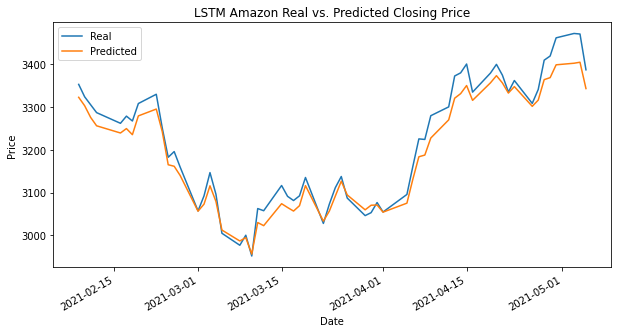

In [ ]:
# Plot the Amazon real vs predicted values as a line chart
amzn_predict.plot(title="LSTM Amazon Real vs. Predicted Closing Price", figsize=(10,5), ylabel="Price");

In [ ]:
# Recover the original Google prices
googl_predicted = scalers["GOOGL"].inverse_transform(pred_results[1]).ravel()
googl_real = scalers["GOOGL"].inverse_transform(test[1].reshape(-1, 1)).ravel()

In [ ]:
# Create a DataFrame of Google real and predicted values
googl_predict = pd.DataFrame({
    "Real": googl_real,
    "Predicted": googl_predicted
}, index = googl_df.index[-len(googl_real): ]) 
googl_predict.head()

,Real,Predicted
Date,,
2021-02-09,2182.987739,2203.843262
2021-02-10,2185.841977,2207.546875
2021-02-11,2199.901746,2215.548828
2021-02-12,2189.436204,2208.972412
2021-02-16,2207.513049,2223.663574


In [ ]:
# Calculate Google MSE & RMSE
googl_mse = mean_squared_error(googl_real, googl_predicted)
googl_rmse = math.sqrt(googl_mse)
googl_mean = googl_predicted.mean()
print(f"Google Mean Square Error: {googl_mse}")
print(f"Google Root Mean Square Error: {googl_rmse}")
print(f"Google Mean Predicted Closing Price: {googl_mean}")

Google Mean Square Error: 146.64337352675128
Google Root Mean Square Error: 12.109639694340673
Google Mean Predicted Closing Price: 2196.791259765625


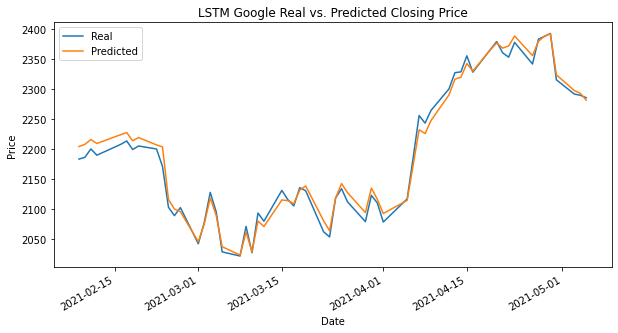

In [ ]:
# Plot the Google real vs predicted values as a line chart
googl_predict.plot(title="LSTM Google Real vs. Predicted Closing Price", figsize=(10,5), ylabel="Price");

In [ ]:
# Recover the original Microsoft prices
msft_predicted = scalers["MSFT"].inverse_transform(pred_results[2]).ravel()
msft_real = scalers["MSFT"].inverse_transform(test[2].reshape(-1, 1)).ravel()

In [ ]:
# Create a DataFrame of Microsoft real and predicted values
msft_predict = pd.DataFrame({
    "Real": msft_real,
    "Predicted": msft_predicted
}, index = msft_df.index[-len(msft_real): ]) 
msft_predict.head()

,Real,Predicted
Date,,
2021-02-09,233.356420,231.917252
2021-02-10,232.885331,232.141068
2021-02-11,231.880720,231.358551
2021-02-12,233.075469,232.800568
2021-02-16,233.208850,233.374908


In [ ]:
# Calculate Microsoft MSE & RMSE
msft_mse = mean_squared_error(msft_real, msft_predicted)
msft_rmse = math.sqrt(msft_mse)
msft_mean = msft_predicted.mean()
print(f"Microsoft Mean Square Error: {msft_mse}")
print(f"Microsoft Root Mean Square Error: {msft_rmse}")
print(f"Microsoft Mean Predicted Closing Price: {msft_mean}")

Microsoft Mean Square Error: 2.6630775570744563
Microsoft Root Mean Square Error: 1.6318938559460465
Microsoft Mean Predicted Closing Price: 238.74456787109375


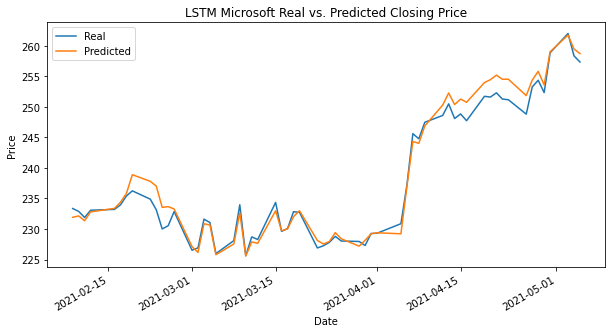

In [ ]:
# Plot the Google real vs predicted values as a line chart
msft_predict.plot(title="LSTM Microsoft Real vs. Predicted Closing Price", figsize=(10,5), ylabel="Price");